In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import numpy as np


import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset

#Get rid of SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  


In [2]:
PNW = pd.read_csv('../../Data/processedData/PNW/PNW.csv')
PNW = PNW.dropna()
PNW["flowering"] = PNW['reproductiveCondition'].isin(['flowering','flowering|fruiting','flowering|fruiting|flower budding','flowering|flower budding']).astype(int)
PNW["fruiting"] = PNW['reproductiveCondition'].isin(['fruiting','flowering|fruiting','flowering|fruiting|flower budding','fruiting|flower budding']).astype(int)

photoPath = "D:\PNW_Angiosperms\labeled_photos"

In [3]:
#I only have 49,999 so I'm missing one photo. The following code drops that row from the dataframe
for fname in PNW['file_name']: 
    if not os.path.isfile(photoPath + "/" + fname):
        PNW = PNW[PNW['file_name'] != fname]

In [4]:
photos = PNW[["file_name", "flowering"]].reset_index(drop=True)
photos_train, photos_val = train_test_split(list(photos.index), test_size=.25)
p_train= photos.iloc[photos_train]
p_val = photos.iloc[photos_val]

In [5]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#Some of our images are .pngs, we drop the alpha. 
train_transform = v2.Compose([
    #Rely on the v2 transforms from torchvision.transforms.v2

    #Use tensors instead of PIL images

    #Use torch.uint8 dtype, especially for resizing
                                v2.ToPILImage(),
                                v2.ToTensor(),
                                v2.RandomAffine(degrees=(-180,180), translate=(0,.1), scale=(.9,1)),
                                v2.RandomHorizontalFlip(p=0.5),
                                v2.RandomVerticalFlip(p=0.5),
                                v2.ColorJitter(brightness=.3, hue=.01),
                                v2.Resize ( (256,256) , interpolation=2 ),
                                v2.CenterCrop(224),
                                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

                            ])
val_transform = v2.Compose([
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                v2.ToPILImage(),
                                v2.ToTensor(),
                                torchvision.transforms.Resize ( (224,224) , interpolation=2 ),
                                v2.Resize ( (256,256) , interpolation=2 ),
                                v2.CenterCrop(224),
                                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])
target_transform = v2.Compose([
                                v2.Lambda(lambda x: torch.tensor(x).long()),
                            ])                         

c:\Users\Sean Haight\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, label_frame, img_dir, transform=None, target_transform=None):
        self.img_labels = label_frame
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [8]:
train_data = CustomImageDataset(p_train, photoPath, train_transform, target_transform)
val_data = CustomImageDataset(p_val, photoPath, val_transform, target_transform)

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


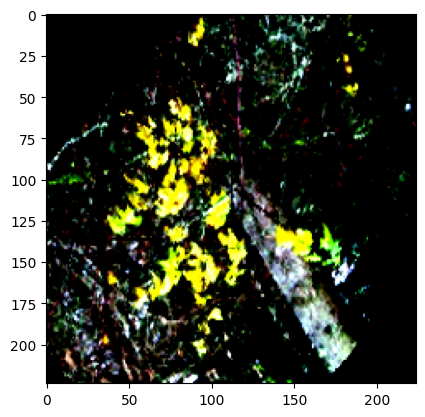

Label: 0


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [11]:
def train(model, num_epochs, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        
        #Turn the model into training mode
        model.train()
        for data, target in train_dataloader:
            optimizer.zero_grad()
            data = data.to(device)
            output = model(data)
            target=target.to(device)   
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            train_correct += (pred == target).sum().item()

        train_loss /= len(train_dataloader.dataset)
        train_acc = 100.0 * train_correct / len(train_dataloader.dataset)

        test_loss = 0.0
        test_correct = 0
        model.eval()

        with torch.no_grad():
            for data, target in val_dataloader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = criterion(output, target)

                test_loss += loss.item() * data.size(0)
                _, pred = torch.max(output, 1)
                test_correct += (pred == target).sum().item()

        test_loss /= len(val_dataloader.dataset)
        test_acc = 100.0 * test_correct / len(val_dataloader.dataset)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

In [12]:
model18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model18.parameters(), lr=0.001, momentum=0.9)
model18.to(device)
train(model18, 40, .001)

Using cache found in C:\Users\Sean Haight/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Sean Haight\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sean Haight\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
#According to Bum Jun Kim I want to add dropout after the last batch normalization but before the last weight layer in the residual branch.

In [12]:
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class SeanBlock(BasicBlock):
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(SeanBlock, self).__init__(inplanes, planes, stride, downsample, groups, base_width, dilation, norm_layer)
        self.dropout_prob = .25
        
    def forward(self,x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.Dropout(self.dropout_prob)(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
    
class SeanBottleneck(Bottleneck):
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(SeanBottleneck, self).__init__(inplanes, planes, stride, downsample, groups, base_width, dilation, norm_layer)
        self.dropout_prob = .25
    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.Dropout(self.dropout_prob)(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.Dropout(self.dropout_prob)(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class MyResNet50(ResNet):
    def __init__(self):
        super(MyResNet50, self).__init__(SeanBottleneck, [3, 4, 6, 3])
        
    def forward(self, x):
        # change forward here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


model = MyResNet50()
# if you need pretrained weights
model.load_state_dict(models.resnet50(weights=True).state_dict())

criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.to(device)
train(model, 11, .001)

c:\Users\Sean Haight\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.5998, Train Acc: 72.55%, Test Loss: 0.4275, Test Acc: 77.91%
Epoch 2: Train Loss: 0.4309, Train Acc: 78.11%, Test Loss: 0.4055, Test Acc: 79.90%
Epoch 3: Train Loss: 0.4097, Train Acc: 79.66%, Test Loss: 0.3902, Test Acc: 80.74%
Epoch 4: Train Loss: 0.3956, Train Acc: 80.43%, Test Loss: 0.3821, Test Acc: 80.99%
Epoch 5: Train Loss: 0.3884, Train Acc: 81.14%, Test Loss: 0.3783, Test Acc: 81.58%
Epoch 6: Train Loss: 0.3767, Train Acc: 81.79%, Test Loss: 0.3781, Test Acc: 82.05%
Epoch 7: Train Loss: 0.3762, Train Acc: 81.80%, Test Loss: 0.3702, Test Acc: 81.66%
Epoch 8: Train Loss: 0.3697, Train Acc: 82.04%, Test Loss: 0.3602, Test Acc: 82.98%
Epoch 9: Train Loss: 0.3654, Train Acc: 82.59%, Test Loss: 0.3758, Test Acc: 81.81%
Epoch 10: Train Loss: 0.3603, Train Acc: 82.71%, Test Loss: 0.3636, Test Acc: 82.37%
Epoch 11: Train Loss: 0.3570, Train Acc: 83.00%, Test Loss: 0.3697, Test Acc: 82.06%


In [19]:
train(model, 1, .001)

Epoch 1: Train Loss: 0.3344, Train Acc: 84.39%, Test Loss: 0.3615, Test Acc: 82.50%
